# Propagation Time Flat Reflector Experiments

In [11]:
import sys, os

basepath = os.path.abspath("../..")
sys.path.append(basepath)
sys.path.append(basepath + "/Operators")
sys.path.append(basepath + "/Utilities")

# Import the linearized Born modeling operators

In [12]:
import numpy as np
import scipy as sp
from scipy import ndimage
import time
import matplotlib.pyplot as plt
%matplotlib inline

from devito import configuration
configuration['log-level'] = 'WARNING'

import DevitoOperators
from DevitoUtils import create_model, plot_image, plot_image_tx, plot_shotrecord
from examples.seismic.acoustic import AcousticWaveSolver
from examples.seismic import plot_velocity, plot_perturbation, demo_model, AcquisitionGeometry

## Create models


Plot of background velocity v1


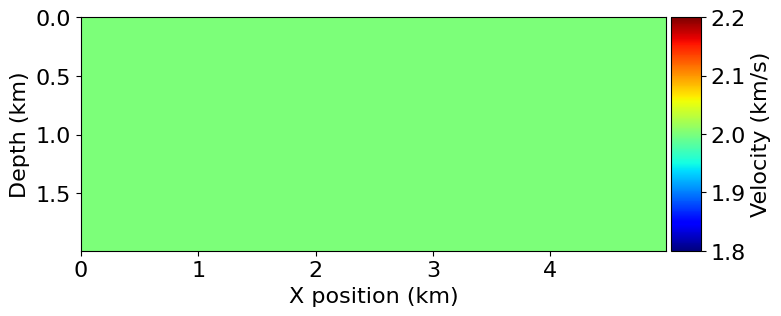


Plot of true velocity v1'


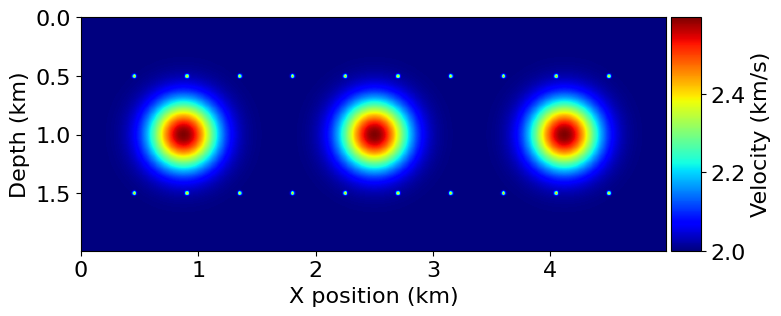

In [13]:
# Create params dicts
params1 = {
    "Nx": 500,
    "Nz": 200,
    "Nt": 100,   # this has to be updated later
    "nbl": 75,
    "Ns": 3,
    "Nr": 200,
    "so": 4,
    "to": 2
}

######################################################
# This part of the code creates the models
######################################################
# Create models
v1 = create_model(shape=(params1["Nx"], params1["Nz"]))
v1.vp.data[:, :] = 2.0

# Initialize based on params1
dv = np.zeros(shape=(params1["Nx"] + 2 * params1["nbl"], params1["Nz"] + 2 * params1["nbl"]), dtype=np.float32)
n0 = dv.shape[0]
n1 = dv.shape[1]

# We will put 3 wide Gaussians in center, and t narrower Gaussians on top and bottom of it

t = 10
sigma_big = 20
sigma_small = 1
amplitude_big = 1500.0
amplitude_small = 3.0

big_gaussian = dv * 0
big_gaussian[int(n0 * 0.5), int(n1 * 0.5)] = 1
big_gaussian = ndimage.gaussian_filter(input=big_gaussian, sigma=sigma_big)
dv += amplitude_big * big_gaussian

big_gaussian = dv * 0
big_gaussian[int(n0 * 0.25), int(n1 * 0.5)] = 1
big_gaussian = ndimage.gaussian_filter(input=big_gaussian, sigma=sigma_big)
dv += amplitude_big * big_gaussian

big_gaussian = dv * 0
big_gaussian[int(n0 * 0.75), int(n1 * 0.5)] = 1
big_gaussian = ndimage.gaussian_filter(input=big_gaussian, sigma=sigma_big)
dv += amplitude_big * big_gaussian

step = int(params1["Nx"] / (t + 1))
for i in range(t):
    small_gaussian = dv * 0
    small_gaussian[params1["nbl"] + (i + 1) * step, params1["nbl"] + int(params1["Nz"] * 0.25)] = 1
    small_gaussian = ndimage.gaussian_filter(input=small_gaussian, sigma=sigma_small)
    dv += amplitude_small * small_gaussian
for i in range(t):
    small_gaussian = dv * 0
    small_gaussian[params1["nbl"] + (i + 1) * step, params1["nbl"] + int(params1["Nz"] * 0.75)] = 1
    small_gaussian = ndimage.gaussian_filter(input=small_gaussian, sigma=sigma_small)
    dv += amplitude_small * small_gaussian

del n0, n1, t, sigma_big, sigma_small, amplitude_big, amplitude_small, big_gaussian, step

# Create models
v1_prime = create_model(shape=(params1["Nx"], params1["Nz"]))
v1_prime.vp.data[:, :] = v1.vp.data + dv


######################################################################
# This part of the code creates the acquisition geometry, solvers
######################################################################

# Simulation time, wavelet
t0 = 0.
tn = 4000.          # Simulation last 4 second (4000 ms)
f0 = 0.010          # Source peak frequency is 10Hz (0.010 kHz)

# Reflection acquisition geometry (sources and receivers are equally spaced in X direction)
src_depth = 20.0                        # Depth is 20m
rec_depth = 20.0                        # Depth is 20m

src_coord = np.empty((params1["Ns"], 2))
if params1["Ns"] == 1:
    src_coord[:, 0] = 0.5 * v1.domain_size[0]
    src_coord[:, 1] = src_depth
else:
    src_coord[:, 0] = np.linspace(0, v1.domain_size[0], num=params1["Ns"])
    src_coord[:, 1] = src_depth

rec_coord = np.empty((params1["Nr"], 2))
rec_coord[:, 0] = np.linspace(0, v1.domain_size[0], num=params1["Nr"])
rec_coord[:, 1] = rec_depth

# Create the geometry objects for background velocity models
src_dummy = np.empty((1, 2))

src_dummy[0, :] = src_coord[int(src_coord.shape[0] / 2), :]
geometry = AcquisitionGeometry(v1_prime, rec_coord, src_dummy, t0, tn, f0=f0, src_type='Ricker')
params1["Nt"] = geometry.nt

# Define a solver object
solver = AcousticWaveSolver(v1_prime, geometry, space_order=params1["so"])

# Plot the velocities
print("\nPlot of background velocity v1")
plot_velocity(v1)
print("\nPlot of true velocity v1'")
plot_velocity(v1_prime)

## Generate data


 Time to model shots for v1 took  4.828445672988892  sec.

 Time to model shots for v1_prime took  1.584012746810913  sec.

Residuals for model v1 

Shot i =  1


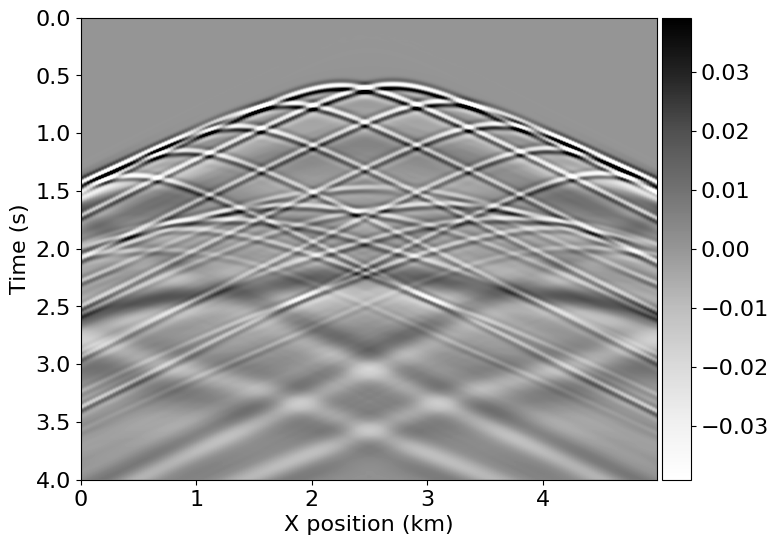

In [14]:
dt = v1_prime.critical_dt

# Allocate numpy arrays to store data
data = np.zeros(shape=(params1["Ns"], params1["Nt"], params1["Nr"]), dtype=np.float32)
data_prime = data * 0

# Call wave_propagator_forward with appropriate arguments
t_start = time.time()
DevitoOperators.wave_propagator_forward(
    data=data,
    src_coords=src_coord,
    vel=v1,
    geometry=geometry,
    solver=solver,
    params=params1
)
t_end = time.time()
print("\n Time to model shots for v1 took ", t_end - t_start, " sec.")

t_start = time.time()
DevitoOperators.wave_propagator_forward(
    data=data_prime,
    src_coords=src_coord,
    vel=v1_prime,
    geometry=geometry,
    solver=solver,
    params=params1
)
t_end = time.time()
print("\n Time to model shots for v1_prime took ", t_end - t_start, " sec.")

# Calculate residuals
res = data - data_prime

print("\nResiduals for model v1 ")
i = int(params1["Ns"] * 0.5)
print("\nShot i = ", i)
plot_shotrecord(res[i, :, :], v1, t0, tn, clip=0.5)

In [18]:
filestr = "gaussian_anomaly1_multi_shot"
dm_invert_multi_shot = np.load(basepath + "/Data/" + filestr + ".npz")["arr_0"]


Plot of inverted stack image


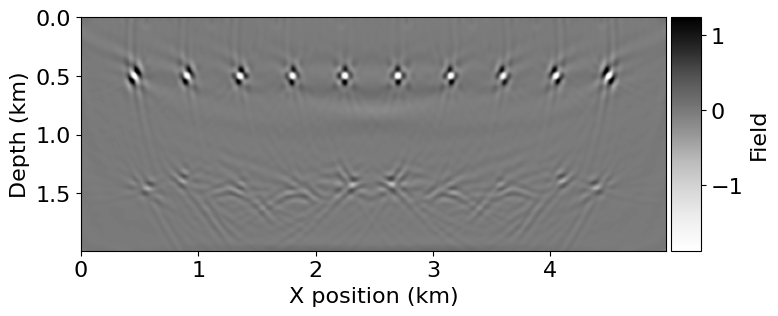


Plot of inverted result at Z = 1.0 km


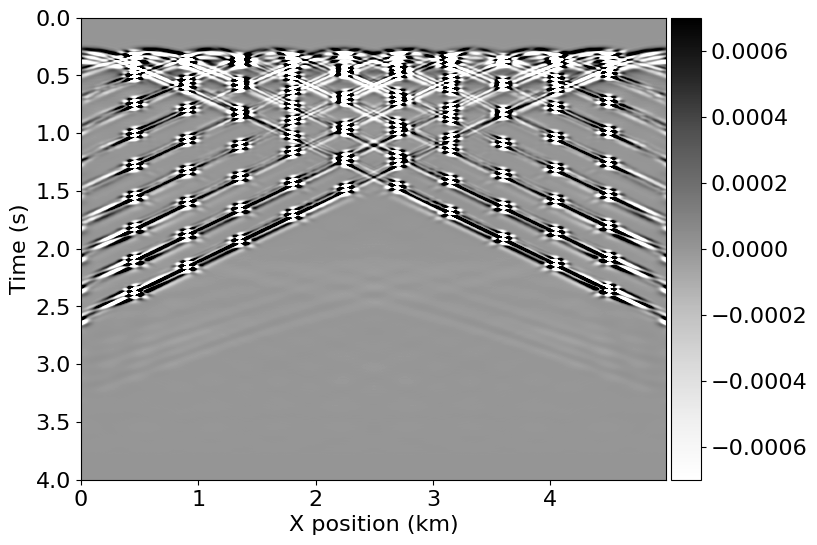

In [19]:
dm_invert_multi_shot_stack = np.sum(dm_invert_multi_shot, axis=0)

# Plot model perturbation stack
temp_model = create_model(shape=(params1["Nx"], params1["Nz"]))
temp_model.vp.data[:, :] *= 0
temp_model.vp.data[params1["nbl"]: params1["Nx"] + params1["nbl"], 
           params1["nbl"]: params1["Nz"] + params1["nbl"]] = dm_invert_multi_shot_stack
print("\nPlot of inverted stack image")
plot_image(temp_model, colorbar=True, colormap="Greys", clip=0.75)
del temp_model

print("\nPlot of inverted result at Z = 1.0 km")
plot_image_tx(dm_invert_multi_shot[:, :, 50], x0=v1.origin[0], xn=v1.origin[0]+v1.domain_size[0], 
              t0=t0, tn=tn, scale=1e-3, clip=0.7)

In [20]:
td_born_data_inverted_model_multi_shot = np.zeros((params1["Ns"], params1["Nt"], params1["Nr"]), dtype=np.float32)

DevitoOperators.td_born_forward(
    model_pert=dm_invert_multi_shot, 
    born_data=td_born_data_inverted_model_multi_shot, 
    src_coords=src_coord, 
    vel=v1, 
    geometry=geometry, 
    solver=solver, 
    params=params1,
    dt=dt
)

Residual original (2nd shot)


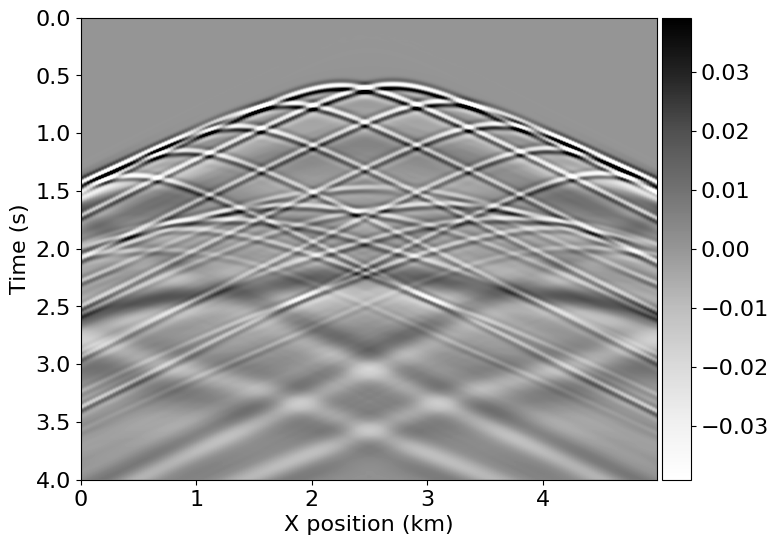

Born data using inverted model (2nd shot)


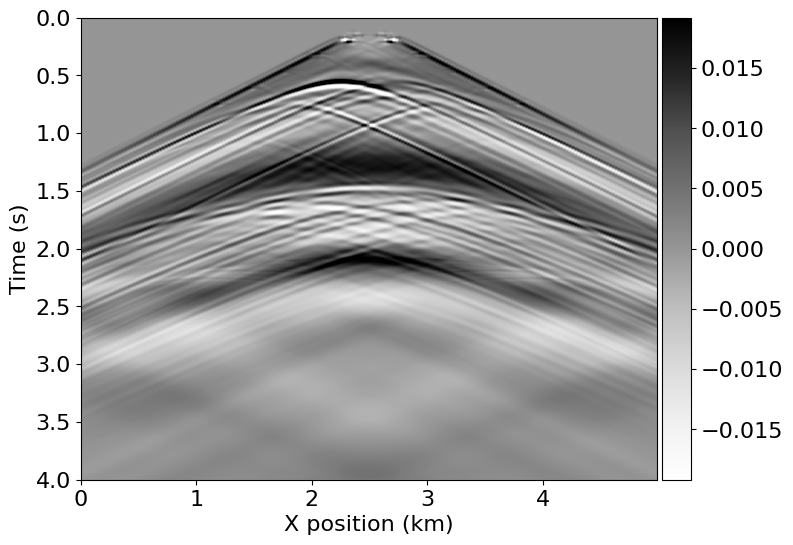

In [21]:
print("Residual original (2nd shot)")
plot_shotrecord(res[1, :, :], v1, t0, tn, clip=0.5)

print("Born data using inverted model (2nd shot)")
plot_shotrecord(td_born_data_inverted_model_multi_shot[1, :, :], v1, t0, tn, clip=0.5)